# **KoBERT 다중 감정 분류 모델**

# Pre Setting

In [ ]:
# GPU 정보
!nvidia-smi

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 라이브러리 설치
!pip install gluonnlp==0.9.1
!pip install pandas
!pip install tqdm
!pip install mxnet
!pip install sentencepiece
!pip install transformers
!pip install torch

# KoBERT 전체 설치
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

# 토크나이저 설치
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-3nvgn13_/kobert-tokenizer_869d12707b154b87b4d953c72ea87aa9
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-3nvgn13_/kobert-tokenizer_869d12707b154b87b4d953c72ea87aa9
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [ ]:
# Hugging Face를 통한 모델 및 토크나이저 Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

# transformer
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
# tokenizer setting
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
tok = tokenizer.tokenize

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
# GPU 설정
device = torch.device("cuda")

# Dataset Preprocessing

In [ ]:
# xlsx 파일을 로드한 뒤 사용할 칼럼을 정리 (감정_대분류, 사람문장1 칼럼만 사용)
# 유니크한 감정 대분류를 뽑아낸 뒤 한글 칼럼명을 숫자로 변경
import pandas as pd
train_set = pd.read_excel('./training_data.xlsx')
validation_set = pd.read_excel('./validation_data.xlsx')

train_set = train_set.loc[:, ['감정_대분류', '사람문장1']]
validation_set = validation_set.loc[:, ['감정분류', '내용']]

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)
train_set.columns = ['label', 'data']
validation_set.columns = ['label', 'data']

train_set.loc[(train_set['label'] == '사랑/기쁨'), 'label'] = 0
train_set.loc[(train_set['label'] == '멘붕/불안'), 'label'] = 1
train_set.loc[(train_set['label'] == '이별/슬픔'), 'label'] = 2
train_set.loc[(train_set['label'] == '스트레스/짜증'), 'label'] = 3
train_set.loc[(train_set['label'] == '우울'), 'label'] = 4

validation_set.loc[(validation_set['label'] == '사랑/기쁨'), 'label'] = 0
validation_set.loc[(validation_set['label'] == '멘붕/불안'), 'label'] = 1
validation_set.loc[(validation_set['label'] == '이별/슬픔'), 'label'] = 2
validation_set.loc[(validation_set['label'] == '스트레스/짜증'), 'label'] = 3
validation_set.loc[(validation_set['label'] == '우울'), 'label'] = 4

# Train & Test split

In [ ]:
# 모델 학습에 사용할 데이터 셋은 [data, label] 배열로 피팅
# 모델 학습에 사용할 훈련 데이터 셋은 기존에 주어진 train_set_data를 4:1 비율로 분리
from sklearn.model_selection import train_test_split

train_set_data = [[i, str(j)] for i, j in zip(train_set['data'], train_set['label'])]
validation_set_data = [[i, str(j)] for i, j in zip(validation_set['data'], validation_set['label'])]

train_set_data, test_set_data = train_test_split(train_set_data, test_size=0.25, random_state=0)

# Data Preprocessing

In [ ]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
class BERTDataset(Dataset):
  def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len, pad, pair):
    transform = nlp.data.BERTSentenceTransform(
        bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

    self.sentences = [transform([i[sent_idx]]) for i in dataset]
    self.labels = [np.int32(i[label_idx]) for i in dataset]

  def __getitem__(self, i):
    return (self.sentences[i] + (self.labels[i], ))

  def __len__(self):
    return (len(self.labels))

In [ ]:
train_set_data = BERTDataset(train_set_data, 0, 1, tok, vocab, max_len, True, False)
test_set_data = BERTDataset(test_set_data, 0, 1, tok, vocab, max_len, True, False)

# BERT 모델에 사용할 데이터 로더
train_dataloader = torch.utils.data.DataLoader(train_set_data, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(test_set_data, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# BERT 모델을 사용할 때 어떤 데이터 클래스를 사용할 것인지 결정해야 함
class BERTClassifier(nn.Module):
  def __init__(self,
              bert,
              hidden_size = 768,
              num_classes=5, # 6가지로 분류
              dr_rate=None,
              params=None):
      super(BERTClassifier, self).__init__()
      self.bert = bert
      self.dr_rate = dr_rate

      self.classifier = nn.Linear(hidden_size, num_classes)
      if dr_rate:
        self.dropout = nn.Dropout(p=dr_rate)

  def gen_attention_mask(self, token_ids, valid_length):
    attention_mask = torch.zeros_like(token_ids)
    for i, v in enumerate(valid_length):
      attention_mask[i][:v] = 1
    return attention_mask.float()

  def forward(self, token_ids, valid_length, segment_ids):
    attention_mask = self.gen_attention_mask(token_ids, valid_length)

    _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
    if self.dr_rate:
      out = self.dropout(pooler)
    return self.classifier(out)

In [ ]:
# BERT 모델 불러오기
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

# optimizer와 schedule 설정
# weight decay 값 0.05
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay':0.1},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate) # weight decay의 효율적 적용을 위한 SGD optimize fun
loss_fn = nn.CrossEntropyLoss() # 다중 분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
# 정확도 측정 함수
def calc_accuracy(X, Y):
  max_vals, max_indices = torch.max(X, 1)
  train_acc = (max_indices == Y).sum().data.cpu().numpy() / max_indices.size()[0]
  return train_acc
train_dataloader

# Train Model

In [ ]:
train_history = []
test_history = []
loss_history = []

# 에폭을 10로 설정하고 훈련
for e in range(num_epochs):
  train_acc = 0.0
  test_acc = 0.0
  model.train()

  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
    optimizer.zero_grad()
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)

    # 출력 (label.shape, out.shape)
    loss = loss_fn(out, label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    scheduler.step() # Update learning rate schedule
    train_acc += calc_accuracy(out, label)
    if batch_id % log_interval == 0:
      print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
  print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
  train_history.append(train_acc / (batch_id+1))
  loss_history.append(loss.data.cpu().numpy())
  model.eval()

  # test
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    test_acc += calc_accuracy(out, label)
  print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
  test_history.append(test_acc / (batch_id+1))

<ipython-input-18-d78adc6d471d>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/624 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.6444857120513916 train acc 0.21875
epoch 1 batch id 201 loss 1.1341757774353027 train acc 0.3537002487562189
epoch 1 batch id 401 loss 1.1511127948760986 train acc 0.4483322942643391
epoch 1 batch id 601 loss 1.161998987197876 train acc 0.4918365224625624
epoch 1 train acc 0.4950527987637363


<ipython-input-18-d78adc6d471d>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/208 [00:00<?, ?it/s]

epoch 1 test acc 0.6007228231837607


  0%|          | 0/624 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.340561866760254 train acc 0.484375
epoch 2 batch id 201 loss 0.8370773196220398 train acc 0.5841884328358209
epoch 2 batch id 401 loss 0.9276148676872253 train acc 0.5959710099750624
epoch 2 batch id 601 loss 1.0699113607406616 train acc 0.6054492512479202
epoch 2 train acc 0.606938959478022


  0%|          | 0/208 [00:00<?, ?it/s]

epoch 2 test acc 0.6169921875


  0%|          | 0/624 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.2068053483963013 train acc 0.53125
epoch 3 batch id 201 loss 0.7157045602798462 train acc 0.6302083333333334
epoch 3 batch id 401 loss 0.8384348154067993 train acc 0.6430798004987531
epoch 3 batch id 601 loss 0.9601948261260986 train acc 0.6548200915141431
epoch 3 train acc 0.6567758413461539


  0%|          | 0/208 [00:00<?, ?it/s]

epoch 3 test acc 0.6129356971153845


  0%|          | 0/624 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.1190534830093384 train acc 0.578125
epoch 4 batch id 201 loss 0.610081136226654 train acc 0.6821361940298507
epoch 4 batch id 401 loss 0.774268627166748 train acc 0.6978647132169576
epoch 4 batch id 601 loss 0.790522038936615 train acc 0.7121724209650583
epoch 4 train acc 0.7142427884615384


  0%|          | 0/208 [00:00<?, ?it/s]

epoch 4 test acc 0.6073334001068376


  0%|          | 0/624 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.9735546112060547 train acc 0.671875
epoch 5 batch id 201 loss 0.5234083533287048 train acc 0.7467350746268657
epoch 5 batch id 401 loss 0.5747681260108948 train acc 0.7629364089775561
epoch 5 batch id 601 loss 0.5833321213722229 train acc 0.7742564475873545
epoch 5 train acc 0.7759415064102564


  0%|          | 0/208 [00:00<?, ?it/s]

epoch 5 test acc 0.5959785657051282


  0%|          | 0/624 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.914283037185669 train acc 0.703125
epoch 6 batch id 201 loss 0.36929574608802795 train acc 0.8006840796019901
epoch 6 batch id 401 loss 0.7578452229499817 train acc 0.8134351620947631
epoch 6 batch id 601 loss 0.7607938051223755 train acc 0.8229253327787022
epoch 6 train acc 0.824043469551282


  0%|          | 0/208 [00:00<?, ?it/s]

epoch 6 test acc 0.6034905849358975


  0%|          | 0/624 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.8055334687232971 train acc 0.78125
epoch 7 batch id 201 loss 0.35147011280059814 train acc 0.8488805970149254
epoch 7 batch id 401 loss 0.443434476852417 train acc 0.8524002493765586
epoch 7 batch id 601 loss 0.6963315010070801 train acc 0.861714850249584
epoch 7 train acc 0.8623547676282052


  0%|          | 0/208 [00:00<?, ?it/s]

epoch 7 test acc 0.6008296607905983


  0%|          | 0/624 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.6093559265136719 train acc 0.828125
epoch 8 batch id 201 loss 0.2006693035364151 train acc 0.880907960199005
epoch 8 batch id 401 loss 0.30338478088378906 train acc 0.8850140274314214
epoch 8 batch id 601 loss 0.507643461227417 train acc 0.8920029118136439
epoch 8 train acc 0.8927283653846154


  0%|          | 0/208 [00:00<?, ?it/s]

epoch 8 test acc 0.5957331730769231


  0%|          | 0/624 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.5701723694801331 train acc 0.8125
epoch 9 batch id 201 loss 0.09404245018959045 train acc 0.8993314676616916
epoch 9 batch id 401 loss 0.16813164949417114 train acc 0.9067175810473815
epoch 9 batch id 601 loss 0.4789085388183594 train acc 0.9096817803660566
epoch 9 train acc 0.909980969551282


  0%|          | 0/208 [00:00<?, ?it/s]

epoch 9 test acc 0.5951004941239316


  0%|          | 0/624 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.5710390210151672 train acc 0.828125
epoch 10 batch id 201 loss 0.07331483066082001 train acc 0.9114583333333334
epoch 10 batch id 401 loss 0.2560088336467743 train acc 0.9163809226932669
epoch 10 batch id 601 loss 0.4850703477859497 train acc 0.9215630199667221
epoch 10 train acc 0.9220252403846154


  0%|          | 0/208 [00:00<?, ?it/s]

epoch 10 test acc 0.597697983440171


# Save Model

In [ ]:
# 모델 저장하기
import os
os.chdir('./model')
os.getcwd()

In [ ]:
# 기본 경로 설정
path = f'./model/'

# 전체 모델 저장
torch.save(model, path + 'EmotionAnalysis_model.pt')

# 파라미터 저장
torch.save(model.state_dict(), path + 'EmotionAnalysis_StateDict.pt')

# 전체 dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, 'EmotionAnalysis_all.tar')

# Load Model

In [ ]:
# 경로 설정
import os
os.chdir('./model/')

# 전체 모델 로드
model = torch.load(f'EmotionAnalysis_model.pt')

# 파라미터 로드
model.load_state_dict(torch.load('EmotionAnalysis_StateDict.pt'))

# 전체 dict 불러오기
checkpoint = torch.load('EmotionAnalysis_all.tar')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

<bound method Module.eval of BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

# Predict Function

In [ ]:
# 주어진 문장이 현재 학습이 완료된 모델 내에서 어떤 라벨과 argmax인지 판단하고 추론된 결과를 리턴하는 함수.
def predict(sentence):

  # 다중 문장 처리
  sentence_split = re.split(r'[,.?!~]', sentence)

  # 양쪽 공백 제거
  for sentence_i in sentence_split:
    sentence_i = sentence_i.lstrip()
    sentence_i = sentence_i.rstrip()

    # 빈 문장일 때는 종료
    if len(sentence_i) <= 0:
      result = "내용을 입력해주세요."
      return result

    # 빈 문장이 아닐 때
    else
      dataset = [[sentence_i, '0']]
      test = BERTDataset(dataset, 0, 1, tok, vocab, max_len, True, False)
      test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=5)
      model.eval()

      answer = 0

      for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval = []

        for logits in out:
          logits = logits
          logits = logits.detach().cpu().numpy()

          if np.argmax(logits) == 0:
            test_eval.append("사랑/기쁨")
          elif np.argmax(logits) == 1:
            test_eval.append("멘붕/불안")
          elif np.argmax(logits) == 2:
            test_eval.append("이별/슬픔")
          elif np.argmax(logits) == 3:
            test_eval.append("스트레스/짜증")
          elif np.argmax(logits) == 4:
            test_eval.append("우울")

        result = ">> 입력하신 내용에서 " + test_eval[0] + "이/가 느껴집니다."
        return result

# Visualization

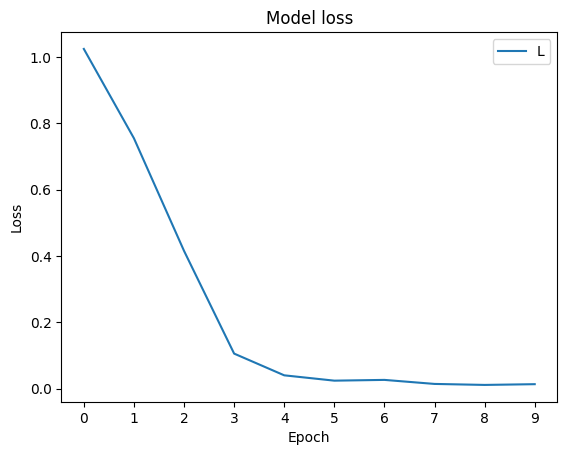

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.title("Model loss")
plt.plot(loss_history)
ax = plt.subplot()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend('Loss')
plt.show()

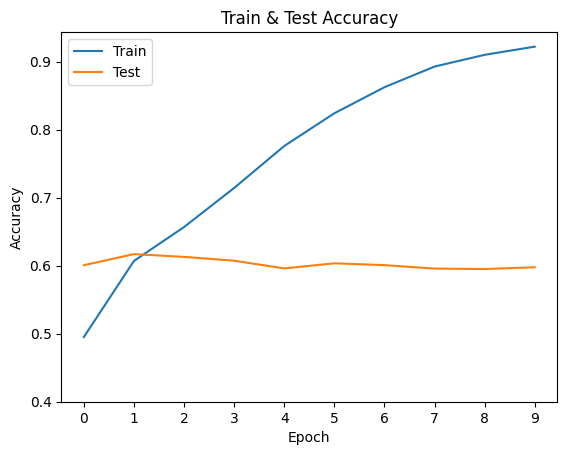

In [ ]:
plt.title("Train & Test Accuracy")

plt.plot(train_history)
plt.plot(test_history)
ax = plt.subplot()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

# Test

In [ ]:
# 캐시 삭제
import gc
gc.collect()
torch.cuda.empty_cache()

Mon Jun 12 18:15:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    48W / 400W |    823MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
end = 1
while end == 1:
    setence = input("내용을 입력해주세요: ")
    if sentence == "0":
      break
    predict(sentece)
    print("\n")

# Flask-ngrok Deployment


In [ ]:
!pip install flask-ngrok
!pip install pyngrok==4.1.1
!ngrok authtoken 2S695AaiZEpRgT78LEw5uDbeJez_6FcrjMJ3jRWQ23rCjoUms

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
import re

In [ ]:
from flask.templating import render_template
from flask import Flask, jsonify, request
from flask_ngrok import run_with_ngrok
import requests

template_folder = '/content/drive/MyDrive/Musling/templates'
app = Flask(__name__, template_folder=template_folder)
run_with_ngrok(app)


@app.route("/")
def analysis():
  diary = input("Your Diary Content: ")
  sentence = predict(diary)
  return render_template('analysis.html', result=sentence)
app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://f5f8-34-124-236-143.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040
Your Diary Content: 오랜만에 먹어서 그런지 너무 맛있었다! 다음에 친구랑 더 맛있는 거 먹어야지~


INFO:werkzeug:127.0.0.1 - - [04/Jul/2023 09:59:22] "GET / HTTP/1.1" 200 -


>> 입력하신 내용에서 사랑/기쁨이/가 느껴집니다.
